Reproduce: SimPEG OcTree
=======================

## Simulating Secondary Magnetic Field Data over a Conductive and Susceptible Layered Earth

Secondary magnetic fields are simulated over a conductive 1D layered Earth. From the top layer down we defined 3 layers with electrical conductivities $\sigma_1$ = 0.05 S/m, $\sigma_2$ = 0.5 S/m and $\sigma_3$ = 0.05 S/m. The magnetic susceptibilities of the layers are $\chi_1$ = 1 SI, $\chi_2$ = 0 SI and $\chi_2$ = 1 SI. The thicknesses of the top two layers are both 64 m.

Secondary magnetic fields are simulated for x, y and z oriented magnetic dipole sources at (0,0,5). For each source, the x, y and z components of the response are simulated at (10,0,5). We plot only the horizontal coaxial, horizontal coplanar and vertical coplanar data.

## SimPEG Package Details

**Link to the docstrings for the simulation.** The docstrings will have a citation and show the integral equation.

## Reproducing the Forward Simulation Result

We begin by loading all necessary packages and setting any global parameters for the notebook.

In [1]:
from discretize.utils import mkvc, refine_tree_xyz
from discretize import TreeMesh
import SimPEG.electromagnetics.frequency_domain as fdem
from SimPEG import maps
from SimPEG.utils import model_builder

from pymatsolver import Pardiso

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.constants import mu_0

mpl.rcParams.update({"font.size": 10})
write_output = True

The survey geometry for the forward simulation is very simple and is defined here.

In [2]:
xyz_tx = np.c_[0., 0., 5.]           # Transmitter location
xyz_rx = np.c_[10., 0., 5.]          # Receiver location
frequencies = np.logspace(2,5,10)    # Frequencies
tx_moment = 1.                       # Dipole moment of the transmitter

A compressed folder containing the assets required to run the notebook is then downloaded. This includes mesh and model files for the forward simulation.

In [3]:
# Download .tar files

Extracted files are then loaded into the SimPEG framework.

In [4]:
rootdir = './../../../assets/fdem/layered_earth_susceptible_fwd_simpeg/'
meshfile = rootdir + 'octree_mesh.txt'
conmodelfile = rootdir + 'model.con'
susmodelfile = rootdir + 'model.sus'

mesh = TreeMesh.readUBC(meshfile)
sigma_model = TreeMesh.readModelUBC(mesh, conmodelfile)
chi_model = TreeMesh.readModelUBC(mesh, susmodelfile)

D:\Documents\Repositories\discretize\discretize\mixins\mesh_io.py:594: FutureWarning: TensorMesh.readUBC has been deprecated and will be removed indiscretize 1.0.0. please use TensorMesh.read_UBC
  warnings.warn(
D:\Documents\Repositories\discretize\discretize\utils\code_utils.py:217: FutureWarning: TreeMesh.readModelUBC has been deprecated, please use TreeMesh.read_model_UBC. It will be removed in version 1.0.0 of discretize.
  warnings.warn(


Below, we plot the discretization and conductivity model used in the forward simulation.

D:\Documents\Repositories\discretize\discretize\base\base_tensor_mesh.py:1036: FutureWarning: hy has been deprecated, please access as mesh.h[1]
  warnings.warn(


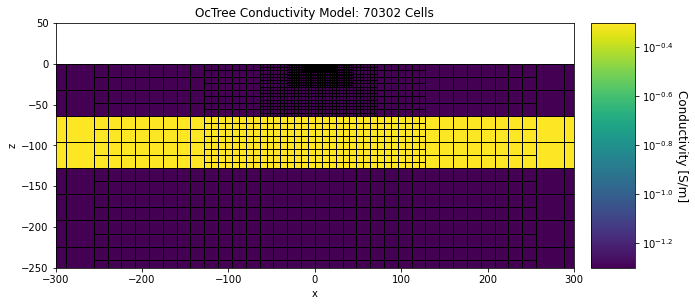

In [5]:
fig = plt.figure(figsize=(12,4))
ind_active = mesh.cell_centers[:, 2] < 0
plotting_map = maps.InjectActiveCells(mesh, ind_active, np.nan)
log_model = np.log10(sigma_model[ind_active])

ax1 = fig.add_axes([0.14, 0.1, 0.6, 0.85])
mesh.plot_slice(
    plotting_map * log_model,
    normal="Y", ax=ax1, ind=int(mesh.hy.size / 2), clim=(np.min(log_model), np.max(log_model)),
    grid=True
)

ax1.set_xlim([-300, 300])
ax1.set_ylim([-250, 50])
ax1.set_title("OcTree Conductivity Model: {} Cells".format(mesh.nC))

ax2 = fig.add_axes([0.76, 0.1, 0.05, 0.85])
norm = mpl.colors.Normalize(
    vmin=np.min(log_model), vmax=np.max(log_model)
)
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", format="$10^{%.1f}$"
)
cbar.set_label("Conductivity [S/m]", rotation=270, labelpad=15, size=12)

And here were plot the susceptibility model.

D:\Documents\Repositories\discretize\discretize\mixins\mpl_mod.py:529: FutureWarning: pcolorOpts has been deprecated, please use pcolor_opts
  warnings.warn(


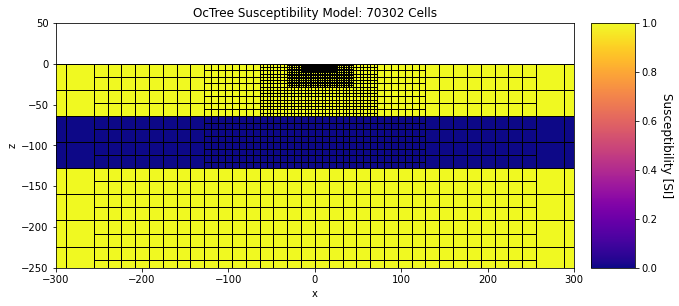

In [6]:
fig = plt.figure(figsize=(12,4))

ax1 = fig.add_axes([0.14, 0.1, 0.6, 0.85])
mesh.plot_slice(
    plotting_map * chi_model[ind_active], normal="Y", ax=ax1, ind=int(mesh.hy.size / 2),
    clim=(np.min(chi_model), np.max(chi_model)), grid=True, pcolorOpts={'cmap':'plasma'}
)

ax1.set_xlim([-300, 300])
ax1.set_ylim([-250, 50])
ax1.set_title("OcTree Susceptibility Model: {} Cells".format(mesh.nC))

ax2 = fig.add_axes([0.76, 0.1, 0.05, 0.85])
norm = mpl.colors.Normalize(
    vmin=np.min(chi_model), vmax=np.max(chi_model)
)
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.plasma
)
cbar.set_label("Susceptibility [SI]", rotation=270, labelpad=15, size=12)

Here, we define the survey geometry for the forward simulation.

In [7]:
source_list = []

for ii in range(0, len(frequencies)):

    receivers_list = [
        fdem.receivers.PointMagneticFluxDensitySecondary(xyz_rx, "x", "real"),
        fdem.receivers.PointMagneticFluxDensitySecondary(xyz_rx, "x", "imag"),
        fdem.receivers.PointMagneticFluxDensitySecondary(xyz_rx, "y", "real"),
        fdem.receivers.PointMagneticFluxDensitySecondary(xyz_rx, "y", "imag"),
        fdem.receivers.PointMagneticFluxDensitySecondary(xyz_rx, "z", "real"),
        fdem.receivers.PointMagneticFluxDensitySecondary(xyz_rx, "z", "imag")
        ]

    for jj in ['x','y','z']:
        source_list.append(
            fdem.sources.MagDipole(receivers_list, frequencies[ii], mkvc(xyz_tx), orientation=jj)
        )

survey = fdem.Survey(source_list)

We now complete the setup for the forward simulation by defining the mapping from the model to the mesh and the simulation.

In [8]:
sigma_map = maps.IdentityMap(nP=mesh.nC)

sim = fdem.simulation.Simulation3DMagneticFluxDensity(
    mesh, survey=survey, sigmaMap=sigma_map, verbose=True, forward_only=True, solver=Pardiso
)

mu0 = 4*np.pi*1e-7
mu_model = mu0 * (1 + chi_model)
sim.mu = mu_model

Finally, we predict the secondary magnetic field data for the model provided. The output vector is then reshaped for easier plotting.

In [9]:
Hs_octree = mu_0**-1 * sim.dpred(sigma_model)

Hs_octree = Hs_octree[0::2] + 1.j*Hs_octree[1::2]
Hs_octree = np.reshape(Hs_octree, (len(frequencies), 3, 3))
Hs_octree = [Hs_octree[:, 0, :], Hs_octree[:, 1, :], Hs_octree[:, 2, :]]

D:\Documents\Repositories\discretize\discretize\utils\code_utils.py:182: FutureWarning: TreeMesh.edgeCurl has been deprecated, please use TreeMesh.edge_curl. It will be removed in version 1.0.0 of discretize.
  warnings.warn(message, Warning)


SOLVING FOR FREQ 100.0


D:\Documents\Repositories\discretize\discretize\utils\code_utils.py:217: FutureWarning: TreeMesh.getFaceInnerProduct has been deprecated, please use TreeMesh.get_face_inner_product. It will be removed in version 1.0.0 of discretize.
  warnings.warn(


SOLVING FOR FREQ 215.44346900318845
SOLVING FOR FREQ 464.15888336127773
SOLVING FOR FREQ 1000.0
SOLVING FOR FREQ 2154.4346900318824
SOLVING FOR FREQ 4641.588833612777
SOLVING FOR FREQ 10000.0
SOLVING FOR FREQ 21544.346900318822
SOLVING FOR FREQ 46415.888336127726
SOLVING FOR FREQ 100000.0


D:\Documents\Repositories\discretize\discretize\utils\code_utils.py:217: FutureWarning: TreeMesh.getInterpolationMat has been deprecated, please use TreeMesh.get_interpolation_matrix. It will be removed in version 1.0.0 of discretize.
  warnings.warn(


If desired, we can export the data to a simple text file.

In [10]:
if write_output:
    
    fname_octree = rootdir + 'dpred_octree.txt'
    
    header = 'FREQUENCY HX_REAL HX_IMAG HY_REAL HY_IMAG HZ_REAL HZ_IMAG'
    f_column = np.kron(np.ones(3), frequencies)
    
    out_array = np.vstack(Hs_octree)
    out_array = np.c_[
        f_column,
        np.real(out_array[:, 0]),
        np.imag(out_array[:, 0]),
        np.real(out_array[:, 1]),
        np.imag(out_array[:, 1]),
        np.real(out_array[:, 2]),
        np.imag(out_array[:, 2])
    ]

    fid = open(fname_octree, 'w')
    np.savetxt(fid, out_array, fmt='%.6e', delimiter=' ', header=header)
    fid.close()

## Plotting Simulated Data

Here, we plot only the horizontal coaxial, horizontal coplanar and vertical coplanar data.

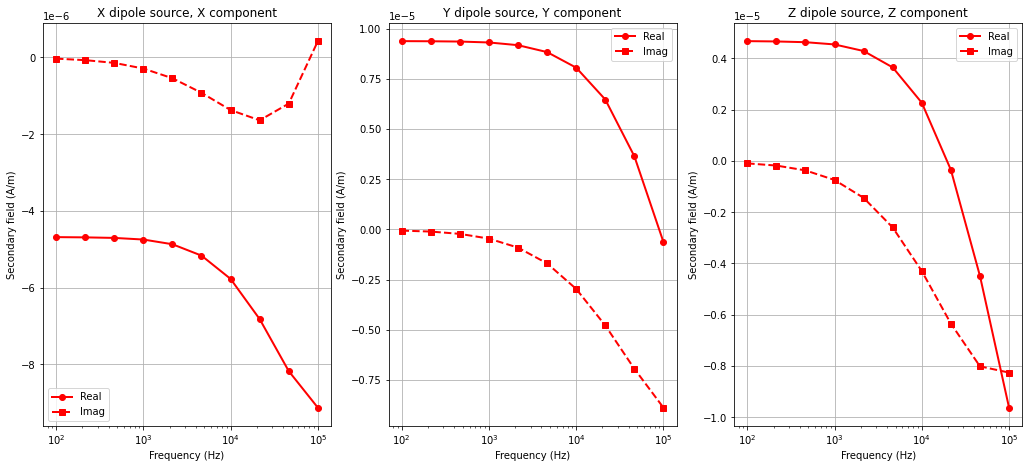

In [11]:
fig = plt.figure(figsize=(16, 7))
lw = 2
ms = 6

ax = 3*[None]

legend_str = ['Real', 'Imag']

for ii, src in enumerate(['X','Y','Z']):
    
        ax[ii] = fig.add_axes([0.05 + 0.3*ii, 0.1, 0.25, 0.8])
        ax[ii].semilogx(frequencies, np.real(Hs_octree[ii][:, ii]), 'r-o', lw=lw, markersize=ms)
        ax[ii].semilogx(frequencies, np.imag(Hs_octree[ii][:, ii]), 'r--s', lw=lw, markersize=ms)
        ax[ii].grid()
        ax[ii].set_xlabel('Frequency (Hz)')
        ax[ii].set_ylabel('Secondary field (A/m)')
        ax[ii].set_title(src + ' dipole source, ' + src + ' component')
        ax[ii].legend(legend_str)